<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments-Flower/blob/main/Endpoint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MODELLO CENTRALIZZATO SU ENDPOINT 1:

imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

dataset

In [204]:
from datasets import load_dataset
dataset = load_dataset("anastasiafrosted/my_sequences_endpoint1", download_mode="force_redownload")

train-00000-of-00001.parquet:   0%|          | 0.00/8.57M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/471k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/117440 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6694 [00:00<?, ? examples/s]

In [211]:
training_set = pd.DataFrame(dataset['train'])
test_set = pd.DataFrame(dataset['test'])

In [212]:
x_train = training_set.copy()
x_test = test_set.copy()

In [213]:
# Pop two target features into y_train and y_test
y_train = x_train[['avg_execution_time_target', 'avg_scheduling_time_target']]
y_test = x_test[['avg_execution_time_target', 'avg_scheduling_time_target']]

# Save aside timestamps
x_train_timestamps = x_train['timestamp_seq']
x_test_timestamps = x_test['timestamp_seq']

y_train_timestamps = x_train['timestamp_target']
y_test_timestamps = x_test['timestamp_target']

# Drop the targets from predictors
x_train = x_train.drop(['avg_execution_time_target', 'avg_scheduling_time_target', 'timestamp_seq', 'timestamp_target'], axis=1)
x_test = x_test.drop(['avg_execution_time_target', 'avg_scheduling_time_target', 'timestamp_seq', 'timestamp_target'], axis=1)

columns = x_train.columns.tolist()
targets = ['avg_execution_time_target', 'avg_scheduling_time_target']

In [214]:
# Extract the first value of each list
first_values = np.array([timestamps[0] for timestamps in x_test_timestamps[:-1]])
print(len(first_values))
last_sequence = x_test_timestamps[-1:][1:]
timestamps = np.concatenate([first_values, last_sequence])

6693


In [215]:
print(timestamps)

['2023-06-26:0:0' '2023-06-26:0:1' '2023-06-26:0:10' ... '2023-07-03:1:48'
 '2023-07-03:1:49' '2023-07-03:1:5']


In [216]:
# Convert each column to a 2D NumPy array (samples x timesteps)
x_train_as_arrays = [np.array(x_train[col].to_list()) for col in columns]
x_test_as_arrays = [np.array(x_test[col].to_list()) for col in columns]

y_train_as_arrays = [np.array(y_train[col].to_list()) for col in targets]
y_test_as_arrays = [np.array(y_test[col].to_list()) for col in targets]

In [217]:
# Stack columns to create a 3D array (samples, timesteps, features)
x_train = np.stack(x_train_as_arrays, axis=-1)
x_test = np.stack(x_test_as_arrays, axis=-1)

y_train = np.stack(y_train_as_arrays, axis=-1)
y_test = np.stack(y_test_as_arrays, axis=-1)

# Verify the shape of the final 3D array
print(f"x_train shape: {x_train.shape}")  # Expected: (104837, timesteps, 14)
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (117440, 7, 11)
x_test shape: (6694, 7, 11)
y_train shape: (117440, 7, 2)
y_test shape: (6694, 7, 2)


model

In [218]:
# Check GPU availability
if tf.test.gpu_device_name():
    print(f"GPU disponibile: {tf.test.gpu_device_name()}")
else:
    print("GPU non disponibile. L'esecuzione potrebbe essere più lenta.")

GPU non disponibile. L'esecuzione potrebbe essere più lenta.


In [284]:
# Class for the LSTM model
class Lstm:
    def __init__(self, learning_rate, sequence_length, num_features, dropout_rate=0.2):
        self.learning_rate = learning_rate
        self.sequence_length = sequence_length  # Number of timesteps in each sequence
        self.num_features = num_features  # Number of features per timestep
        self.dropout_rate = dropout_rate

        # Define the LSTM-based model
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.sequence_length, self.num_features)),  # Input shape for LSTM
            tf.keras.layers.LSTM(
                50,  # Increased number of units for better learning
                activation='relu',
                return_sequences=True,
                kernel_regularizer=tf.keras.regularizers.l2(0.01),  # L2 regularization
                recurrent_dropout=self.dropout_rate  # Recurrent Dropout
            ),
            tf.keras.layers.Dropout(self.dropout_rate),  # Dropout for regularization
            tf.keras.layers.BatchNormalization(),  # Batch Normalization to stabilize training
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, activation='linear'))  # Final output layer for each timestep
        ])

        # Define the loss function and optimizer
        self.loss_function = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def compile(self):
        # Compile the model with optimizer, loss, and additional metrics
        self.model.compile(optimizer=self.optimizer, loss=self.loss_function,
                           metrics=["cosine_similarity", tf.keras.metrics.MeanAbsoluteError()])

    def get_model(self):
        return self.model


In [285]:
# Usage example
learning_rate = 0.01
sequence_length = 7  # Number of timesteps in each sequence
num_features = 11  # Number of features per timestep

# Instantiate and compile the model
lstm_model = Lstm(learning_rate, sequence_length, num_features)
lstm_model.compile()

# Summary of the model
print(lstm_model.get_model().summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 7, 50)               │          12,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 50)               │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 7, 2)                │             102 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,702 (49.62 KB)

 Trainable params: 12,602 (49.23 KB)

 Non-trainable params: 100 (400.00 B)

None


Training

In [286]:
# Train the model
history = lstm_model.get_model().fit(
    x_train, y_train,
    epochs=10,  # Adjust epochs as needed
    batch_size=16,  # Batch size for training
    validation_split=0.2  # Use 20% of the data for validation
)

Epoch 1/10
5872/5872 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - cosine_similarity: 0.7208 - loss: 0.7032 - mean_absolute_error: 0.0483 - val_cosine_similarity: 0.9803 - val_loss: 2.4575 - val_mean_absolute_error: 0.0638
Epoch 2/10
5872/5872 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - cosine_similarity: 0.7870 - loss: 0.6610 - mean_absolute_error: 0.0376 - val_cosine_similarity: 0.9888 - val_loss: 2.4577 - val_mean_absolute_error: 0.0626
Epoch 3/10
5872/5872 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - cosine_similarity: 0.7715 - loss: 0.8232 - mean_absolute_error: 0.0419 - val_cosine_similarity: 0.7960 - val_loss: 2.4597 - val_mean_absolute_error: 0.0707
Epoch 4/10
5872/5872 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - cosine_similarity: 0.7497 - loss: 0.7090 - mean_absolute_error: 0.0410 - val_cosine_similarity: 0.9734 - val_loss: 2.4582 - val_mean_absolute_error: 0.0638
Epoch 5/10
5872/5872 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - cosine_similarity: 0.7631 - loss: 0.7363 - mean_absolute_error: 0.0407 - val_cosine_similar

In [287]:
print("Input Data Statistics (x_train):")
print(f"Mean: {x_train.mean()}, Std Dev: {x_train.std()}")
print("\nTarget Data Statistics (y_train):")
print(f"Mean: {y_train.mean()}, Std Dev: {y_train.std()}")

Input Data Statistics (x_train):
Mean: 2.8926407432344825, Std Dev: 4.029540675953805

Target Data Statistics (y_train):
Mean: 0.03314248069965891, Std Dev: 1.0281780184729161


graph loss

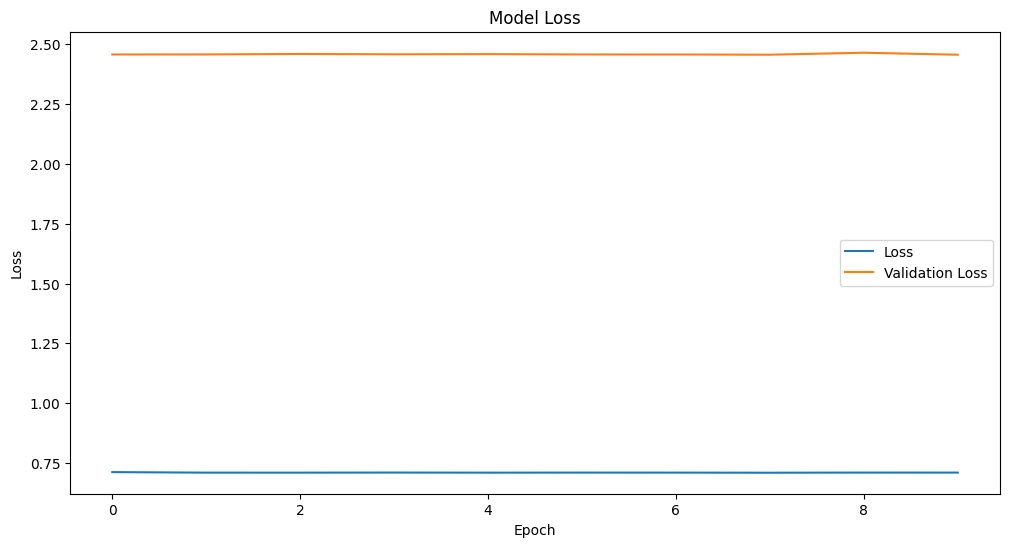

In [288]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluation

In [289]:
# Evaluate the model on test data
test_loss, *test_metrics = lstm_model.get_model().evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
for i, metric in enumerate(test_metrics):
    print(f"Test Metric {i+1}: {metric}")

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.5249 - loss: 4.3612e-04 - mean_absolute_error: 0.0120
Test Loss: 0.0009280639351345599
Test Metric 1: 0.5261459946632385
Test Metric 2: 0.011773824691772461


Prediction

In [290]:
# Generate predictions
y_pred = lstm_model.get_model().predict(x_test, verbose=1)

print(f"Predictions shape: {y_pred.shape}")
print(f"First prediction: {y_pred[0]}")


210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predictions shape: (6694, 7, 2)
First prediction: [[0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]]


In [291]:
print(f"Predictions shape: {y_pred.shape}")
print(f"First prediction: {y_pred[1]}")

Predictions shape: (6694, 7, 2)
First prediction: [[0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]
 [0.008 0.015]]


In [292]:
# FEATURE 1

# Step 1: Prendi la prima target feature (feature 1)
y_pred_feature1 = y_pred[:, :, 0]  # Shape: (num_samples, timesteps)
y_test_feature1 = y_test[:, :, 0]  # Shape: (num_samples, timesteps)

# Step 2: Prendi il primo valore per ogni sequenza eccetto l'ultima
first_values_pred = np.array([seq[0] for seq in y_pred_feature1[:-1]])
first_values_actual = np.array([seq[0] for seq in y_test_feature1[:-1]])

# Step 3: Aggiungi l'intera ultima sequenza
last_sequence_pred = y_pred_feature1[-1]  # L'ultima sequenza completa
last_sequence_actual = y_test_feature1[-1]  # L'ultima sequenza completa

# Step 4: Combina i valori in un unico array
new_array_pred = np.concatenate([first_values_pred, last_sequence_pred])
new_array_actual = np.concatenate([first_values_actual, last_sequence_actual])

In [293]:
print(new_array_pred)
print(new_array_actual)

[0.008 0.008 0.008 ... 0.008 0.008 0.008]
[0.026 0.034 0.017 ... 0.012 0.012 0.012]


In [294]:
# FEATURE 2

# Step 1: Prendi la prima target feature (feature 1)
y_pred_feature2 = y_pred[:, :, 1]  # Shape: (num_samples, timesteps)
y_test_feature2 = y_test[:, :, 1]  # Shape: (num_samples, timesteps)

# Step 2: Prendi il primo valore per ogni sequenza eccetto l'ultima
first_values_pred2 = np.array([seq[0] for seq in y_pred_feature2[:-1]])
first_values_actual2 = np.array([seq[0] for seq in y_test_feature2[:-1]])

# Step 3: Aggiungi l'intera ultima sequenza
last_sequence_pred2 = y_pred_feature2[-1]  # L'ultima sequenza completa
last_sequence_actual2 = y_test_feature2[-1]  # L'ultima sequenza completa

# Step 4: Combina i valori in un unico array
new_array_pred2 = np.concatenate([first_values_pred2, last_sequence_pred2])
new_array_actual2 = np.concatenate([first_values_actual2, last_sequence_actual2])

In [295]:
print(new_array_pred2)
print(new_array_actual2)

[0.015 0.015 0.015 ... 0.015 0.015 0.015]
[0.001 0.001 0.001 ... 0.001 0.001 0.001]


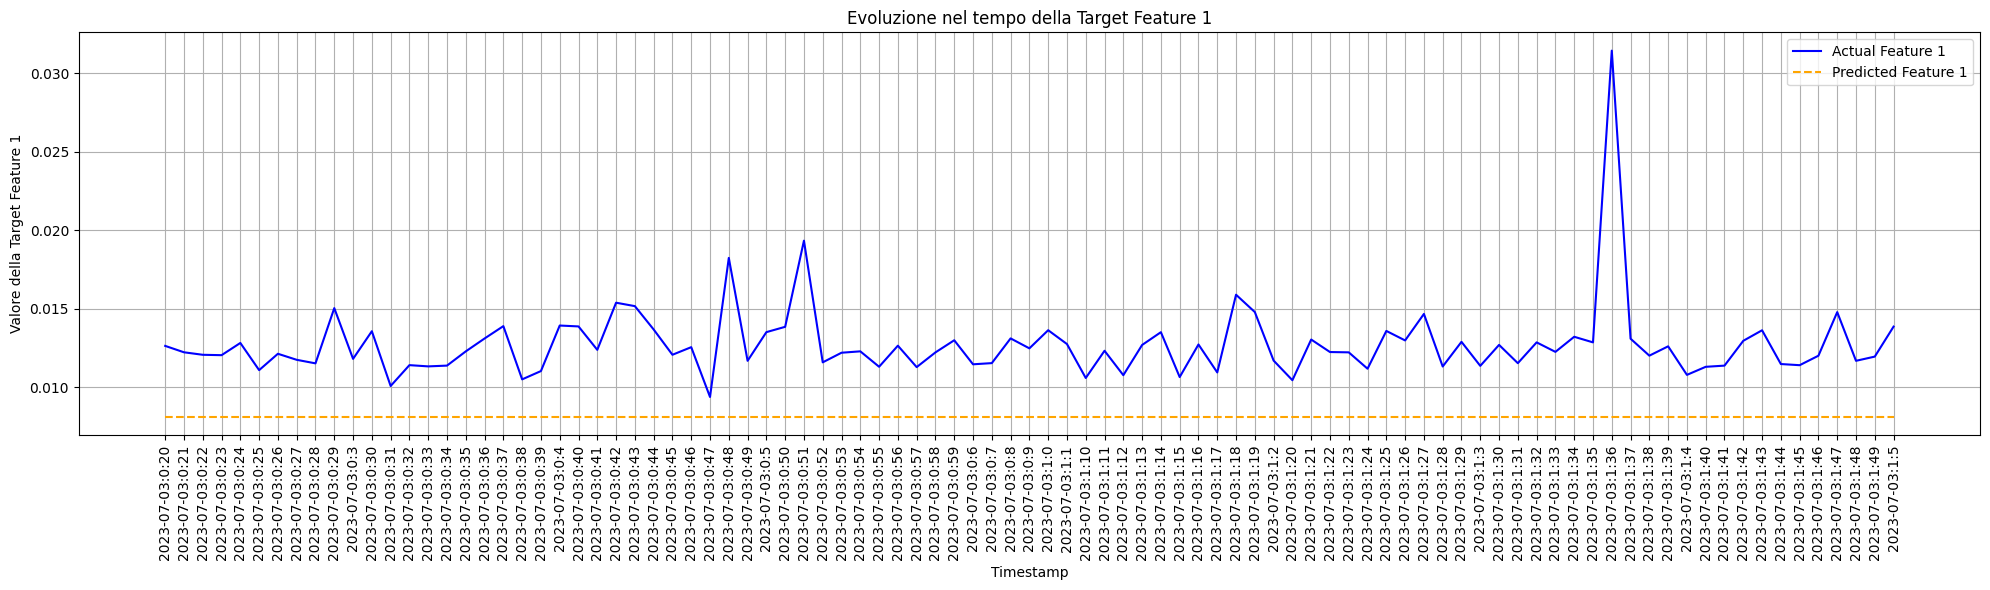

In [296]:
import numpy as np
import matplotlib.pyplot as plt

# Grafico
plt.figure(figsize=(20, 6))
plt.plot(timestamps[6600:], new_array_actual[6600:-7], label='Actual Feature 1', color='blue')
plt.plot(timestamps[6600:], new_array_pred[6600:-7], label='Predicted Feature 1', linestyle='dashed', color='orange')

# Personalizzazione del grafico
plt.title("Evoluzione nel tempo della Target Feature 1")
plt.xlabel("Timestamp")
plt.ylabel("Valore della Target Feature 1")
plt.xticks(rotation=90)  # Rotazione dei timestamp per leggibilità
plt.legend()
plt.grid()
plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()


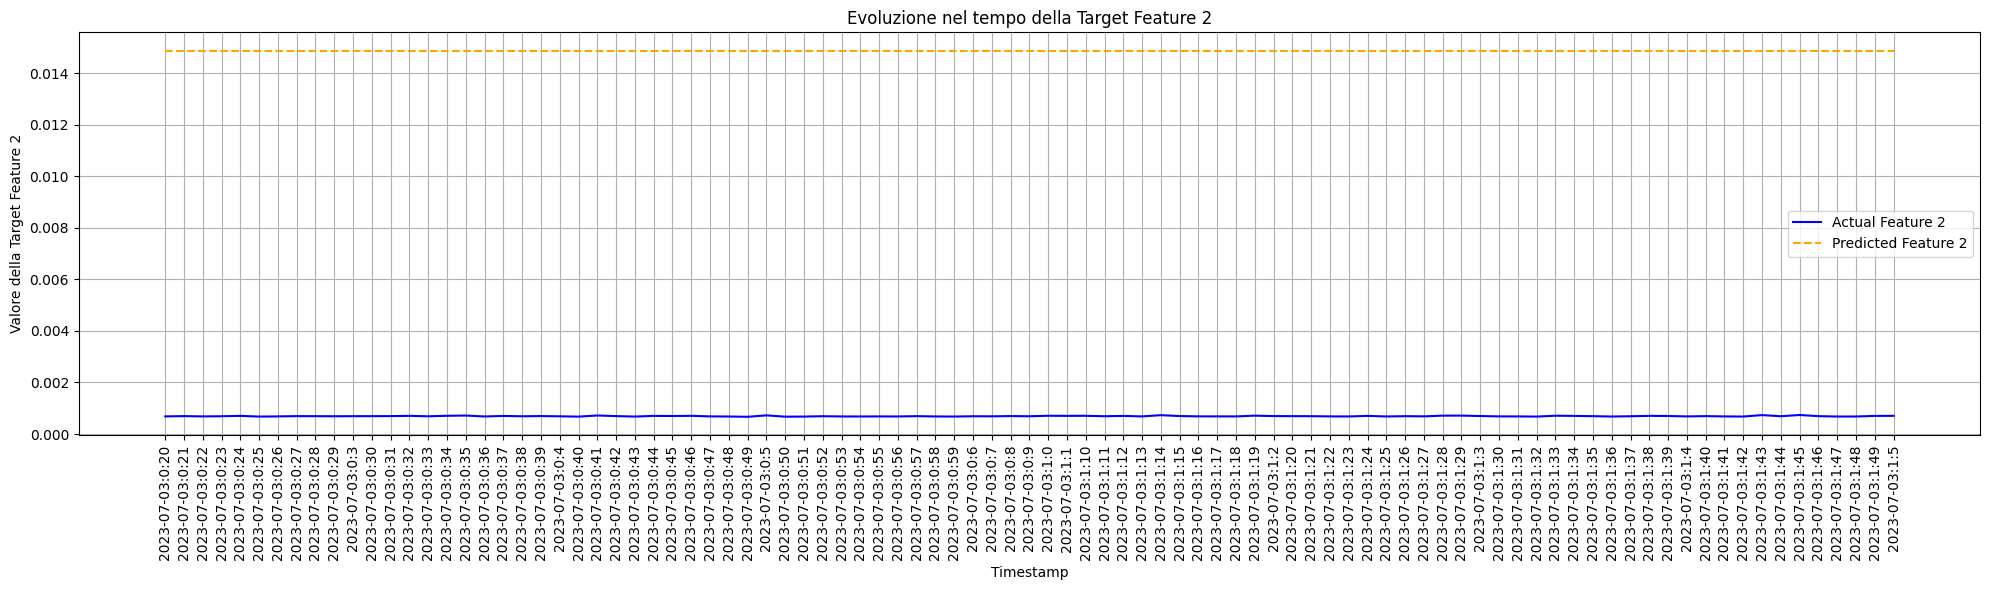

In [297]:
import numpy as np
import matplotlib.pyplot as plt

# Grafico
plt.figure(figsize=(20, 6))
plt.plot(timestamps[6600:], new_array_actual2[6600:-7], label='Actual Feature 2', color='blue')
plt.plot(timestamps[6600:], new_array_pred2[6600:-7], label='Predicted Feature 2', linestyle='dashed', color='orange')

# Personalizzazione del grafico
plt.title("Evoluzione nel tempo della Target Feature 2")
plt.xlabel("Timestamp")
plt.ylabel("Valore della Target Feature 2")
plt.xticks(rotation=90)  # Rotazione dei timestamp per leggibilità
plt.legend()
plt.grid()
plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()